In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go

In [2]:
data = pd.read_csv('/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv')
data.sample(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
134,2006-12-05,9.314689,9.524270,9.221542,9.244829,21264000,0.0,0.0
1707,2013-03-08,50.286043,50.311658,49.755715,50.208248,5068000,0.0,0.0
3438,2020-01-23,322.108526,322.356302,319.452377,322.088715,4188300,0.0,0.0
1182,2011-02-03,22.571355,23.418490,22.387195,23.174831,18662000,0.0,0.0
2252,2015-05-07,87.145378,88.538402,86.799524,88.432724,4369800,0.0,0.0


# Análise de estátisticas - (DATA UNDERSTANDING)
* 1. Estátisticas básicas
* 2. Campos nulos
* 3. Dimensão
* 4. Correlação entre os dados


## Tipo de dado e amostra

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3872 entries, 0 to 3871
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3872 non-null   object 
 1   Open          3872 non-null   float64
 2   High          3872 non-null   float64
 3   Low           3872 non-null   float64
 4   Close         3872 non-null   float64
 5   Volume        3872 non-null   int64  
 6   Dividends     3872 non-null   float64
 7   Stock Splits  3872 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 242.1+ KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3872.0,1.048968e+02,1.062455e+02,3.748967,2.234720e+01,7.081008e+01,1.476884e+02,3.926539e+02
High,3872.0,1.059561e+02,1.073036e+02,4.102467,2.263800e+01,7.137590e+01,1.486454e+02,4.005215e+02
Low,3872.0,1.037693e+02,1.050501e+02,3.739664,2.203446e+01,7.022400e+01,1.468220e+02,3.897478e+02
Close,3872.0,1.048827e+02,1.061687e+02,4.083861,2.230039e+01,7.085608e+01,1.476884e+02,3.946857e+02
Volume,3872.0,1.232250e+07,1.759665e+07,641100.000000,3.529475e+06,5.891750e+06,1.319775e+07,3.953430e+08
Dividends,3872.0,2.329029e-03,2.585085e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e-01
Stock Splits,3872.0,2.582645e-03,1.607061e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01


## Dados em falta

In [5]:
data.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [6]:
data.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

## Definir data como INDEX

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

#data = data.asfreq('D')
data = data.dropna()
# Verificando a frequência
print(data.index.freq)

None


In [8]:
data.index

DatetimeIndex(['2006-05-25', '2006-05-26', '2006-05-30', '2006-05-31',
               '2006-06-01', '2006-06-02', '2006-06-05', '2006-06-06',
               '2006-06-07', '2006-06-08',
               ...
               '2021-09-28', '2021-09-29', '2021-09-30', '2021-10-01',
               '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07',
               '2021-10-08', '2021-10-11'],
              dtype='datetime64[ns]', name='Date', length=3872, freq=None)

## Dimensionalidade e correlação

In [9]:
data.shape

(3872, 7)

<Axes: >

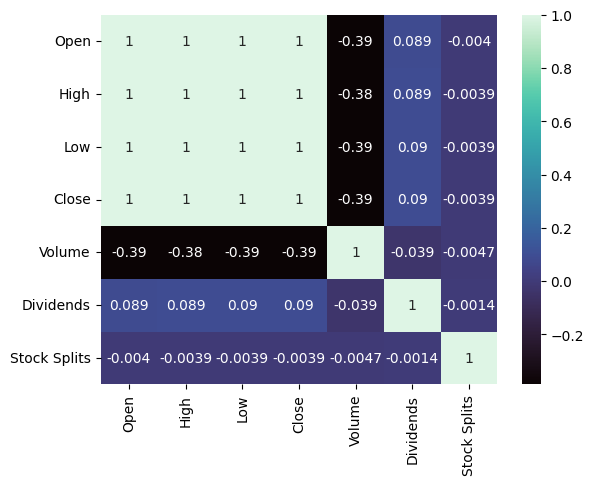

In [10]:
palette = sns.color_palette("mako", as_cmap=True)
corr = data.corr()

sns.heatmap(data=corr,cmap=palette,annot=True)

Existe correlação total entre Open,High,Low e Close

# Análise visual:
* 1. Teste ANOVA
* 2. Análise de tendência: média móvel, regressão, análise de decomposição



## Teste anova

In [11]:
from scipy.stats import f_oneway


anova1 = f_oneway(data['Close'], data['Volume'], data['Stock Splits'], data['Dividends'])
anova2 = f_oneway(data['Close'], data['Open'], data['High'], data['Low'])

print("Estatística F (Variaveis com alta compatibilidade):", anova2.statistic)
print("Valor p:", anova2.pvalue)

print('\n')
print("Estatística F (Variaveis com baixa compatibilidade):", anova1.statistic)
print("Valor p:", anova1.pvalue)

Estatística F (Variaveis com alta compatibilidade): 0.27372092466418846
Valor p: 0.8443976304546679


Estatística F (Variaveis com baixa compatibilidade): 1898.762362151304
Valor p: 0.0


In [12]:
import pandas as pd
from itertools import combinations
from scipy.stats import f_oneway

resultado_anova = []
pares_de_colunas = combinations(data.columns, 2)
for par in pares_de_colunas:
    anova = f_oneway(data[par[0]], data[par[1]])
    resultado_anova.append({'Coluna 1': par[0], 'Coluna 2': par[1], 'Estatística F': anova.statistic, 'Valor p': anova.pvalue})
    
df_resultado = pd.DataFrame(resultado_anova)
df_resultado

,Coluna 1,Coluna 2,Estatística F,Valor p
0,Open,High,0.190523,0.662494
1,Open,Low,0.220484,0.638685
2,Open,Close,0.000034,0.995339
3,Open,Volume,1898.740810,0.000000
4,Open,Dividends,3774.152577,0.000000
5,Open,Stock Splits,3774.125915,0.000000
6,High,Low,0.821065,0.364897
7,High,Close,0.195769,0.658170
8,High,Volume,1898.740483,0.000000
9,High,Dividends,3775.194140,0.000000


## Análise de média móvel

Suavizar a os fechamentos mensais e verificar se há declinio ou aumento

In [13]:
from sklearn.linear_model import LinearRegression as lr

data['mediamovel'] = data['Dividends'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Dividends']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Dividends'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: dividendos',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig

In [14]:
from sklearn.linear_model import LinearRegression as lr

data['mediamovel'] = data['Close'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Close']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='Tendência pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: Fechamento',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig

In [15]:
from sklearn.linear_model import LinearRegression as lr

data['mediamovel'] = data['Volume'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Volume']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Volume'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='Tendência pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: Volume',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig

In [16]:
from sklearn.linear_model import LinearRegression as lr

data['mediamovel'] = data['Stock Splits'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Stock Splits']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Stock Splits'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='Tendência pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: Divisão de ações ',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig

## Análise de decomposição por adição

Análise de sazonalidade e tendência

In [17]:
import statsmodels.api as sm

new_data = data.copy()
new_data['Date'] = pd.to_datetime(new_data.index)
new_data.set_index('Date', inplace=True)
new_data = new_data.asfreq('ME')
new_data.fillna(new_data.mode().iloc[0], inplace=True)

decomposicao = sm.tsa.seasonal_decompose(pd.DataFrame(new_data['Close']), model='additive')

fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index,y=data.Close,mode='lines',name='Original'))
fig.add_trace(go.Scatter(x=decomposicao.trend.index,y=decomposicao.trend.values,mode='lines',name='Tendência'))
fig.add_trace(go.Scatter(x=decomposicao.seasonal.index,y=decomposicao.seasonal.values,mode='lines',name='Sazonalidade'))
fig.add_trace(go.Scatter(x=decomposicao.resid.index,y=decomposicao.resid.values,mode='lines',name='Residuo'))

fig.update_layout(title='Decomposição: Análise de tendência e sazonalidade: Modelo aditivo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

fig

In [18]:
import statsmodels.api as sm

new_data = data.copy()
new_data['Date'] = pd.to_datetime(new_data.index)
new_data.set_index('Date', inplace=True)
new_data = new_data.asfreq('ME')
new_data.fillna(new_data.mode().iloc[0], inplace=True)

decomposicao = sm.tsa.seasonal_decompose(pd.DataFrame(new_data['Close']), model='multiplicative')

fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index,y=data.Close,mode='lines',name='Original'))
fig.add_trace(go.Scatter(x=decomposicao.trend.index,y=decomposicao.trend.values,mode='lines',name='Tendência'))
fig.add_trace(go.Scatter(x=decomposicao.seasonal.index,y=decomposicao.seasonal.values,mode='lines',name='Sazonalidade'))
fig.add_trace(go.Scatter(x=decomposicao.resid.index,y=decomposicao.resid.values,mode='lines',name='Residuo'))

fig.update_layout(title='Decomposição: Análise de tendência e sazonalidade: modelo multiplicativo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

fig


# Machine learning
* Modelos não lineares simples: SVM, Random Forest
* Modelos médios probabilisticos: Cadeias de markov ocultas e ANN

## Adicionar Trend

In [19]:
# data_ = data.copy()
# data_['Trend'] = data_['Close'].diff().apply(lambda x: 'Up' if x > 0 else 'Down')


# data_['Trend'].iloc[0] = 'N/A'
# data_['Trend'].iloc[-1] = 'N/A'

# print(data_.head())

## SVM Poly (3, 5)



In [20]:
# SVM
slice_ = data.loc['2018-01-01':].copy().iloc[1:-2]

slice_


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-03,149.090826,150.745327,148.963567,150.588699,3732400,0.00,0.0
2018-01-04,151.293555,154.093476,151.078191,152.536880,3247200,0.00,0.0
2018-01-05,152.918699,155.699036,152.908915,155.699036,2747700,0.00,0.0
2018-01-08,155.493137,157.356146,155.002870,156.169708,3143100,0.25,0.0
2018-01-09,156.542277,156.993329,155.453883,156.395203,2573900,0.00,0.0
...,...,...,...,...,...,...,...
2021-10-01,349.388549,362.721709,346.721935,359.725494,5227300,0.00,0.0
2021-10-04,359.475786,360.194878,338.911773,343.765656,7901500,0.00,0.0
2021-10-05,347.121403,348.130138,342.497241,342.776886,4724100,0.00,0.0


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

X = slice_[["Open","High","Low"]]
y = slice_["Close"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1,random_state=42)

preprocessing = StandardScaler()
X_train_normalized = preprocessing.fit_transform(X_train)
X_test_normalized  = preprocessing .transform(X_test)

model_poly3 = SVR(kernel='poly', degree=3, C=.03)
model_poly3.fit(X_train_normalized,y_train)

model_poly5 = SVR(kernel='poly', degree=5, C=.03)
model_poly5.fit(X_train_normalized,y_train)

SVR(C=0.03, degree=5, kernel='poly')

In [22]:
y_pred3 = model_poly3.predict(X_train_normalized)
y_pred5 = model_poly5.predict(X_train_normalized)

print("Poly 3: \nMSE: ",mse(y_pred3,y_train),"\nMAE: ",mae(y_pred3,y_train))
print("Poly 5: \nMSE: ",mse(y_pred5,y_train),"\nMAE: ",mae(y_pred5,y_train))

Poly 3: 
MSE:  959.1305557371178 
MAE:  27.5184525972009
Poly 5: 
MSE:  1614.3289648907096 
MAE:  34.82070231600455


In [23]:
import plotly.graph_objs as go
import plotly.io as pio

# Dados originais
trace_orig = go.Scatter(
    x=list(range(len(y_train))),
    y=y_train,
    mode='lines',
    name='Original'
)

# Previsões Poly 3
trace_poly3 = go.Scatter(
    x=list(range(len(y_train))),
    y=y_pred3,
    mode='lines',
    name='Poly 3'
)

# Previsões Poly 5
trace_poly5 = go.Scatter(
    x=list(range(len(y_train))),
    y=y_pred5,
    mode='lines',
    name='Poly 5'
)

# Layout
layout = go.Layout(
    title="Comparação entre Previsões Poly 3, Poly 5 e Original",
    xaxis=dict(title='Index'),
    yaxis=dict(title='Close Price'),
    template="plotly_dark"
)

# Figura
fig = go.Figure(data=[trace_orig, trace_poly3, trace_poly5], layout=layout)

# Exibir o gráfico
pio.show(fig)

## SVM (RBF)


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

data_ = data.copy()

X = data_[["Open","High","Low"]]
y = data_["Close"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1,random_state=42)

preprocessing = StandardScaler()
X_train_normalized = preprocessing.fit_transform(X_train)
X_test_normalized  = preprocessing .transform(X_test)

model_rbf = SVR(kernel='rbf', gamma=2, C=.025)
model_rbf.fit(X_train_normalized,y_train)

SVR(C=0.025, gamma=2)

In [25]:
y_rbf = model_poly3.predict(X_train)

print("RBF: \nMSE: ",mse(y_rbf,y_train),"\nMAE: ",mae(y_rbf,y_train))

RBF: 
MSE:  1.176369897457473e+17 
MAE:  149139140.82752112


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVR was fitted without feature names



## SVM - Categorico (em construção)


In [26]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVR

# X = slice_[["Open","High","Low"]]
# y = slice_["Trend"].astype('category').cat.codes

# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1,random_state=42)

# preprocessing = StandardScaler()
# X_train_normalized = preprocessing.fit_transform(X_train)
# X_test_normalized  = preprocessing .transform(X_test)

# model_poly3 = SVR(kernel='poly', degree=3, C=.03)
# model_poly3.fit(X_train_normalized,y_train)

# model_poly5 = SVR(kernel='poly', degree=5, C=.03)
# model_poly5.fit(X_train_normalized,y_train)

In [27]:
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# from sklearn.metrics import classification_report

# y_pred3 = model_poly3.predict(X_test_normalized)
# y_pred5 = model_poly5.predict(X_test_normalized)

# accuracy3 = accuracy_score(y_test, y_pred3)
# f1_score3 = f1_score(y_test, y_pred3, average='weighted')
# roc_auc3 = roc_auc_score(y_test, model_poly3.predict_proba(X_test_normalized), multi_class='ovr')

# accuracy5 = accuracy_score(y_test, y_pred5)
# f1_score5 = f1_score(y_test, y_pred5, average='weighted')
# roc_auc5 = roc_auc_score(y_test, model_poly5.predict_proba(X_test_normalized), multi_class='ovr')

# # Exibindo os resultados
# print("Modelo Poly 3:\n")
# print(f"Acurácia: {accuracy3:.4f}")
# print(f"F1-Score: {f1_score3:.4f}")
# print(f"ROC-AUC: {roc_auc3:.4f}\n")

# print("Modelo Poly 5:\n")
# print(f"Acurácia: {accuracy5:.4f}")
# print(f"F1-Score: {f1_score5:.4f}")
# print(f"ROC-AUC: {roc_auc5:.4f}\n")

# # Relatório de Classificação
# print("Relatório de Classificação para Poly 3:\n")
# print(classification_report(y_test, y_pred3))

# print("Relatório de Classificação para Poly 5:\n")
# print(classification_report(y_test, y_pred5))

## SSVR (Máquina de suporte de vetores sazonais)
mesmo modelo porém adicionando fatores sazonais, incluindo:
*     dias semana
*     mês
*     feriado



In [28]:
!pip install holidays

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import holidays

slice_sazo = slice_.copy()

hus = holidays.US()

slice_sazo["day"] = slice_sazo.index.dayofweek
slice_sazo["month"] = slice_sazo.index.month
slice_sazo["isHoliDay"] = slice_sazo.index.isin(hus).astype(int)

X = slice_sazo[["Open","High","Low","day","month","isHoliDay"]]
y = slice_sazo["Close"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

preprocessing = StandardScaler()
X_train_normalized = preprocessing.fit_transform(X_train)
X_test_normalized  = preprocessing .transform(X_test)

model_poly3 = SVR(kernel='poly', degree=3,C=1)
model_poly3.fit(X_train_normalized,y_train)

model_poly5 = SVR(kernel='poly', degree=5,C=1)
model_poly5.fit(X_train_normalized,y_train)

SVR(C=1, degree=5, kernel='poly')

In [30]:
y_pred3 = model_poly3.predict(X_train_normalized)
y_pred5 = model_poly5.predict(X_train_normalized)

print("Poly 3 Sazo: \nMSE: ",mse(y_pred3,y_train),"\nMAE: ",mae(y_pred3,y_train))
print("Poly 5 Sazo: \nMSE: ",mse(y_pred5,y_train),"\nMAE: ",mae(y_pred5,y_train))

Poly 3 Sazo: 
MSE:  480.82447827806345 
MAE:  17.758389169936887
Poly 5 Sazo: 
MSE:  1246.9466739667307 
MAE:  28.89273864197601


In [31]:
trace_orig = go.Scatter(
    x=list(range(len(y_train))),
    y=y_train,
    mode='lines',
    name='Original'
)

trace_poly3 = go.Scatter(
    x=list(range(len(y_train))),
    y=y_pred3,
    mode='lines',
    name='Poly 3'
)

trace_poly5 = go.Scatter(
    x=list(range(len(y_train))),
    y=y_pred5,
    mode='lines',
    name='Poly 5'
)

layout = go.Layout(
    title="Comparação entre Previsões Poly 3, Poly 5 e Original - Dados Sazonais",
    xaxis=dict(title='Index'),
    yaxis=dict(title='Close Price'),
    template="plotly_dark"
)

fig = go.Figure(data=[trace_orig, trace_poly3, trace_poly5], layout=layout)

pio.show(fig)

## Bayesian Structural Time Series ( BSTS )



In [32]:
!pip install pymc
!pip install arviz

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.8 MB/s eta 0:00:00
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9097 sha256=ca149778737efd0f7f692141d9a23166508aabf4d012738cbed12d28c2f1ad56
  Stored in directory: /root/.cache/pip/wheels/a4/11/f5/8265470e17d280d8b5910e1b0f298521420a5086d696e96799
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13912 sha256=95f00246b8fd3aac6aaf959c87b834ad19a47e0650c99fbf123bdc97ebd88

### Sem dados sazonais

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import holidays
import pymc as pm
import arviz as az

slice_sazo = slice_.copy()

hus = holidays.US()

slice_sazo["day"] = slice_sazo.index.dayofweek
slice_sazo["month"] = slice_sazo.index.month
slice_sazo["isHoliDay"] = slice_sazo.index.isin(hus).astype(int)

X = slice_sazo[["Open","High","Low"]]
y = slice_sazo["Close"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

preprocessing = StandardScaler()
X_train_normalized = pd.DataFrame(preprocessing.fit_transform(X_train),columns=X.columns)
X_test_normalized  = preprocessing .transform(X_test)

#------------------------------------------------------

X_Open = X_train_normalized["Open"].values
X_High = X_train_normalized["High"].values
X_Low = X_train_normalized["Low"].values

y_target = y_train.values

# prior
with pm.Model() as bsts:
    alpha = pm.Normal("a",0,1)
    beta_Open = pm.Normal("open",0,1)
    beta_High = pm.Normal("high",0,1)
    beta_Low  = pm.Normal("low",0,1)
    
    eps_err = pm.HalfNormal("error_v",1)
    
    mu = alpha + beta_Open * X_Open + beta_High * X_High + beta_Low * X_Low
    
    likelihood = pm.Normal("yobs",mu,eps_err,observed=y_target)

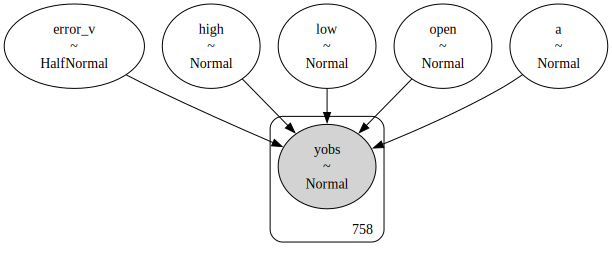

In [34]:
pm.model_to_graphviz(bsts)

In [35]:
with bsts:
    trace = pm.sample()
    print(pm.summary(trace))
    trace = pm.sample_prior_predictive()

Output()

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        28.512  0.997  26.579   30.293      0.021    0.015    2176.0   
error_v  80.509  0.538  79.480   81.462      0.011    0.008    2288.0   
high      5.824  0.933   4.081    7.577      0.022    0.015    1854.0   
low       5.779  0.935   4.011    7.492      0.018    0.013    2767.0   
open      5.783  0.952   4.058    7.633      0.019    0.013    2591.0   

         ess_tail  r_hat  
a          1334.0    1.0  
error_v    1634.0    1.0  
high       1461.0    1.0  
low        1613.0    1.0  
open       1520.0    1.0  


array([<Axes: xlabel='yobs'>], dtype=object)

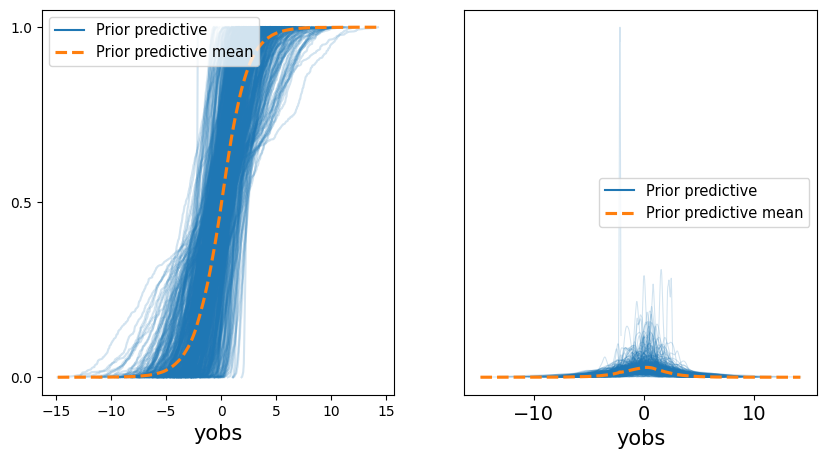

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace, group='prior', kind='cumulative',ax=axes[0])
az.plot_ppc(trace, group='prior',ax=axes[1])

### Com dados sazonais


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import holidays
import pymc as pm
import arviz as az

slice_sazo = slice_.copy()

hus = holidays.US()

slice_sazo["day"] = slice_sazo.index.dayofweek
slice_sazo["month"] = slice_sazo.index.month
slice_sazo["isHoliDay"] = slice_sazo.index.isin(hus).astype(int)

X = slice_sazo[["Open","High","Low","day","month","isHoliDay"]]
y = slice_sazo["Close"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

preprocessing = StandardScaler()
X_train_normalized = pd.DataFrame(preprocessing.fit_transform(X_train),columns=X.columns)
X_test_normalized  = preprocessing .transform(X_test)

#------------------------------------------------------

X_Open = X_train_normalized["Open"].values
X_High = X_train_normalized["High"].values
X_Low = X_train_normalized["Low"].values
X_Day = X_train_normalized["day"].values
X_Month = X_train_normalized["month"].values
X_Holy = X_train_normalized["isHoliDay"].values

y_target = y_train.values

# prior
with pm.Model() as bsts_sazo:
    alpha = pm.Normal("a",0,1)
    beta_Open = pm.Normal("open",0,1)
    beta_High = pm.Normal("high",0,1)
    beta_Low  = pm.Normal("low",0,1)
    
    beta_Day = pm.Normal("day",0,1)
    beta_Month = pm.Normal("month",0,1)
    beta_Holy = pm.Normal("isHoliDay",0,1)
    
    eps_err = pm.HalfNormal("error_v",1)
    
    mu = alpha + beta_Open * X_Open + beta_High * X_High + beta_Low * X_Low + beta_Day * X_Day + beta_Month * X_Month + beta_Holy * X_Holy
    
    likelihood = pm.Normal("yobs",mu,eps_err,observed=y_target)

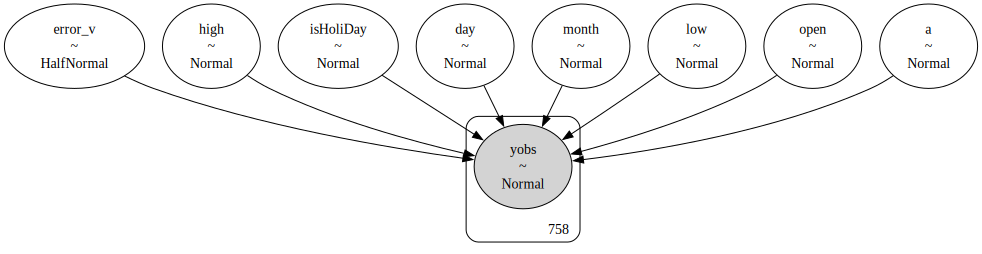

In [38]:
pm.model_to_graphviz(bsts_sazo)

In [39]:
with bsts_sazo:
    trace_sazo = pm.sample()
    print(pm.summary(trace_sazo))
    trace_sazo = pm.sample_prior_predictive()

Output()

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a          28.549  1.013  26.479   30.238      0.021    0.015    2420.0   
day        -0.092  0.947  -1.908    1.667      0.017    0.022    2949.0   
error_v    80.509  0.516  79.599   81.549      0.011    0.008    2058.0   
high        5.791  0.947   3.990    7.569      0.018    0.013    2729.0   
isHoliDay   0.024  0.966  -1.731    1.839      0.021    0.020    2079.0   
low         5.767  0.972   3.985    7.635      0.020    0.014    2378.0   
month       0.625  0.962  -1.278    2.267      0.019    0.018    2622.0   
open        5.770  0.940   4.082    7.638      0.019    0.014    2423.0   

           ess_tail  r_hat  
a            1836.0    1.0  
day          1511.0    1.0  
error_v      1572.0    1.0  
high         1632.0    1.0  
isHoliDay    1524.0    1.0  
low          1742.0    1.0  
month        1628.0    1.0  
open         1544.0    1.0  


array([<Axes: xlabel='yobs'>], dtype=object)

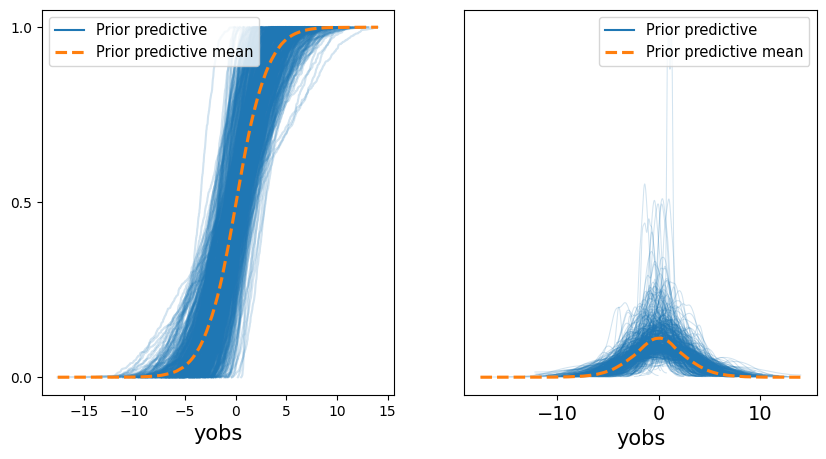

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_sazo, group='prior', kind='cumulative',ax=axes[0])
az.plot_ppc(trace_sazo, group='prior',ax=axes[1])

### Modelo robusto usando distribuição t-student

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import holidays
import pymc as pm
import arviz as az

slice_sazo = slice_.copy()

hus = holidays.US()

slice_sazo["day"] = slice_sazo.index.dayofweek
slice_sazo["month"] = slice_sazo.index.month
slice_sazo["isHoliDay"] = slice_sazo.index.isin(hus).astype(int)

X = slice_sazo[["Open","High","Low","day","month","isHoliDay"]]
y = slice_sazo["Close"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

preprocessing = StandardScaler()
X_train_normalized = pd.DataFrame(preprocessing.fit_transform(X_train),columns=X.columns)
X_test_normalized  = preprocessing .transform(X_test)

#------------------------------------------------------

X_Open = X_train_normalized["Open"].values
X_High = X_train_normalized["High"].values
X_Low = X_train_normalized["Low"].values
X_Day = X_train_normalized["day"].values
X_Month = X_train_normalized["month"].values
X_Holy = X_train_normalized["isHoliDay"].values

y_target = y_train.values

# prior
with pm.Model() as bsts_sazo_robust:
    alpha = pm.Normal("a",0,1)
    beta_Open = pm.Normal("open",0,1)
    beta_High = pm.Normal("high",0,1)
    beta_Low  = pm.Normal("low",0,1)
    
    beta_Day = pm.Normal("day",0,1)
    beta_Month = pm.Normal("month",0,1)
    beta_Holy = pm.Normal("isHoliDay",0,1)
    
    eps_err = pm.HalfNormal("error_v",1)
    
    mu = alpha + beta_Open * X_Open + beta_High * X_High + beta_Low * X_Low + beta_Day * X_Day + beta_Month * X_Month + beta_Holy * X_Holy
    df_f = pm.Exponential("df",1) 
    
    likelihood = pm.StudentT("yobs",mu=mu,sigma=eps_err,nu=df_f,observed=y_target)

In [42]:
with bsts_sazo_robust:
    trace_sazo_robust = pm.sample()
    print(pm.summary(trace_sazo_robust))
    trace_sazo_robust = pm.sample_prior_predictive()

Output()

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a           3.910  0.989   2.018    5.725      0.020    0.014    2531.0   
day        -0.009  1.010  -1.859    1.933      0.019    0.023    2978.0   
df          0.284  0.012   0.262    0.306      0.000    0.000    2528.0   
error_v    14.642  0.734  13.305   15.981      0.015    0.011    2292.0   
high       -1.072  0.985  -2.967    0.610      0.020    0.018    2461.0   
isHoliDay  -0.016  0.970  -1.842    1.707      0.018    0.020    2797.0   
low        -1.094  1.045  -3.148    0.843      0.019    0.018    2940.0   
month      -0.221  1.012  -2.092    1.634      0.020    0.022    2689.0   
open       -1.076  1.018  -2.854    0.842      0.020    0.019    2565.0   

           ess_tail  r_hat  
a            1683.0    1.0  
day          1458.0    1.0  
df           1539.0    1.0  
error_v      1724.0    1.0  
high         1513.0    1.0  
isHoliDay    1547.0    1.0  
low          1497.0    1.0  
month        1578

/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning:

overflow encountered in multiply

/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning:

overflow encountered in reduce

/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:250: RuntimeWarning:

divide by zero encountered in scalar power



array([<Axes: xlabel='yobs'>], dtype=object)

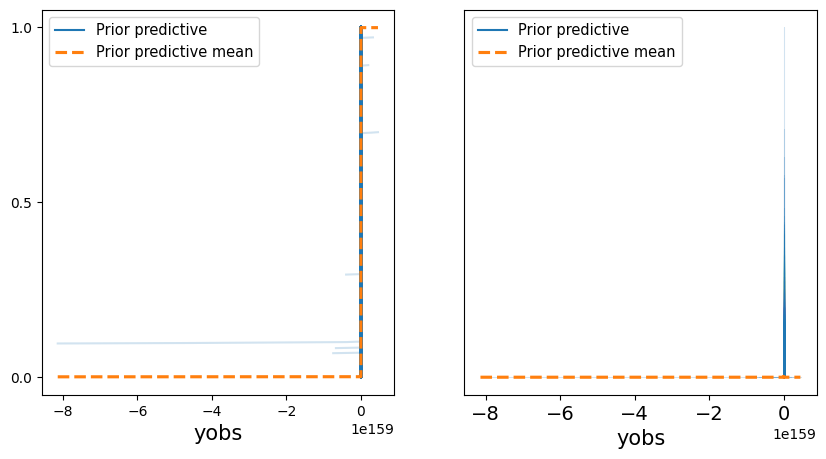

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_sazo_robust, group='prior', kind='cumulative',ax=axes[0])
az.plot_ppc(trace_sazo_robust, group='prior',ax=axes[1])